<a href="https://colab.research.google.com/github/Batman511/AI-Samsung-Neural-Networks/blob/main/%D0%9A%D1%83%D1%80%D1%81_AI_Samsung_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление функции с помощью нейросети (Регрессия)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

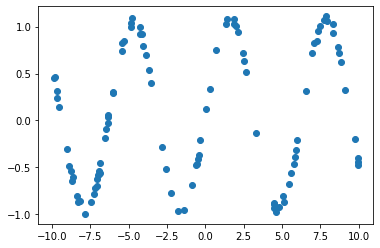

In [ ]:
x_train = torch.rand(100)
x_train *=20
x_train -=10

y_train = torch.sin(x_train)
# plt.plot(x_train.numpy(), y_train.numpy(),'o')

noise = torch.rand(y_train.shape)/8.
y_train += noise

plt.plot(x_train.numpy(), y_train.numpy(),'o')

Превращаем вектор признаков в столбец

In [ ]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

# Сделаем валидационные данные,   СЛЕДИТЬ ЧТОБЫ БЫЛ ТОТ ЖЕ ДИАПАЗОН, ЧТО В ТРЕНИРОВОЧНЫЕ ДАННЫЕ
x_valid = torch.linspace(-10, 10, 100)
y_valid = torch.sin(x_valid.data)

x_valid.unsqueeze_(1)
y_valid.unsqueeze_(1);

Создаем Класс нейросети

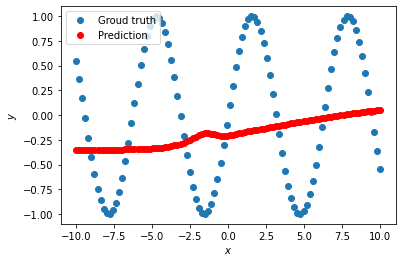

In [ ]:
class SinNet(torch.nn.Module):  # наследуем от класса nn.Module
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(SinNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии
# fc - полносвязный слой!
    # последовательное применение слоев, т.е. ИНИЦИАЛИЗАЦИЯ
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sin_net = SinNet(12)

def predict(net,x,y):
    y_pred = net.forward(x)  # предсказываем
    # рисуем
    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sin_net,x_valid,y_valid)

Обучаем нейросеть

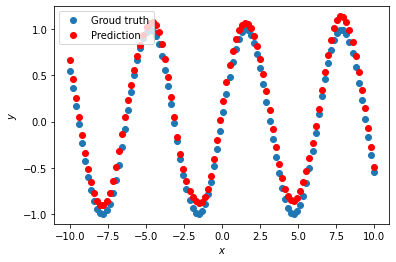

In [ ]:
optimazer = torch.optim.Adam(sin_net.parameters(), lr=0.01)  # в parameters() лежат веса нейронов (настроиваемые) поэтому и наследовали
# оптимайзер оборачивает все параметры нейросети

def loss(pred,target):
    sq = (pred-target)**2
    return sq.mean()

for epoch_index in range(2000):
    optimazer.zero_grad()  # зануляем градиенты
    y_pred = sin_net.forward(x_train)
    loss_val = loss(y_pred,y_train)
    loss_val.backward()  # для оптимайзера
    optimazer.step()

predict(sin_net, x_valid, y_valid)

## Вторая функция

In [ ]:
import torch

def target_function(x):
    return 2**x * torch.sin(2**-x)

class RegressionNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):   # число скрытых нейронов в каждом слое
        super(RegressionNet, self).__init__()  # инициализируем родительский объект
        self.fc1 = torch.nn.Linear(1,n_hidden_neurons)  # первый слой с числом входных и выходных нейронов
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.act1 = torch.nn.Tanh()
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1) # выходной слой с одним выходом тк задача регрессии

    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

net = RegressionNet(30)

# ------Dataset preparation start--------:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)
# ------Dataset preparation end--------:


optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

def loss(pred, target):
    sq = abs(pred-target)
    return sq.mean()

for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = net.forward(x_train)
    loss_value = loss(y_pred, y_train)
    loss_value.backward()
    optimizer.step()

# Проверка:
def metric(pred, target):
   return (pred - target).abs().mean()

print(metric(net.forward(x_validation), y_validation).item())

0.02594063989818096


# Классификация

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)  # для видеокарты отдельно прописываем
torch.backends.cudnn.deterministic = True

Скачиваем базу с 3 видами вина

In [ ]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Создаем выборки и Класс нейросети

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(wine.data[:,:2],  # используем только 2 колонки для визуализации
                                                    wine.target,    # что предсказываем
                                                    test_size=0.3,
                                                    shuffle=True)
# обернем в тензор:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.LongTensor(y_train) # недробные числа
y_test = torch.LongTensor(y_test)

# Нейросеть для классификации
class WineNet(torch.nn.Module):
    # конструктор
    def __init__(self,n_hidden_neurons):
        super(WineNet,self).__init__()

        self.fc1 = torch.nn.Linear(2,n_hidden_neurons)  # 2 входа = 2 колонки
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)  
        self.fc3 = torch.nn.Linear(n_hidden_neurons,3) 
        self.sm = torch.nn.Softmax(dim=1)  # построчное применение

    # граф нейросети
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        return x
# Для подсчета loss softmax не нужен, а для вероятности нужен, поэтому напишем отдельно
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

wine_net = WineNet(5)

# реализация Кроссэнтропии numpy
# def CrossEntropy(y_pred, y_true):
#     total_bce_loss = np.sum(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
#     num_of_samples = y_pred.shape[0]
#     mean_bce_loss = total_bce_loss / num_of_samples
#     return mean_bce_loss

# loss = torch.nn.CrossEntropyLoss()   # не работает
# loss = torch.nn.functional.cross_entropy()   # работает

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [ ]:
np.random.permutation(5)  # индексы в случайном порядке для перемешивания датасета
batch_size=10

for epoch in range(5000):
    order = np.random.permutation(len(x_train)) # порядок индексов

    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = x_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = wine_net.forward(x_batch)
        loss = torch.nn.functional.cross_entropy(preds,y_batch)
        loss.backward()
        optimizer.step()

    # проверяем каждый 100 эпох как идет обучение (валидационные данные)
    if epoch % 100 == 0:
        test_preds = wine_net.forward(x_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())




tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)


Визуализация результата

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-30-5b03a9fb0f65>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plt.scatter(x_train[indexes, 0],


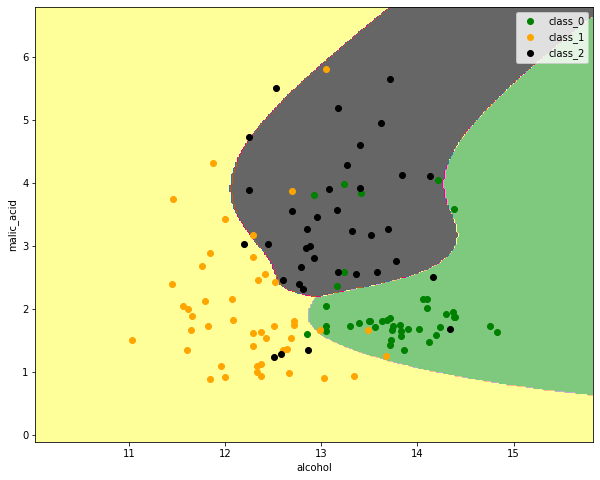

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(x_train[indexes, 0], 
                x_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Если уменьшить число скрытых слоев, качество улучшится

# Классификация рукописных цифр (одномерный тензор)

Обучать следует на GPU (так быстрее)

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True   # если убрать, то скорость увеличится

Скачиваем картинки рукописных цифр

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

# данные в дробных числах
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

Откроем одну картинку

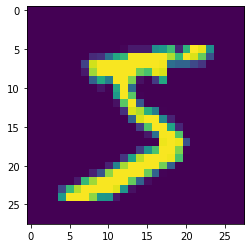

Label:  tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print("Label: ",y_train[0])

Растянем картинки в одномерный тензор

In [ ]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

Создаем нейросеть

In [ ]:
class MNISTNet(torch.nn.Module):
    def __init__(self,n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
        self.ac1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 

    def forward(self,x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)    
        return x

mnist_net = MNISTNet(100)
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)
# torch.nn.functional.cross_entropy()

## Подключаем GPU

In [ ]:
print(torch.cuda.is_available())
# !nvidia-smi  # что за видеокарта и занята ли она вычислениями

True


Перекладываем вычисления весов на GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())  # cuda:0 означаем, что веса лежат на видеокарте

Если памяти хватает, то и данные переносим, но тренировочные перебрасываем батчами

In [ ]:
X_test = X_test.to(device)
y_test = y_test.to(device)

## Обучаем

Ставим большое число эпох с рассчетом на что, что сделаем остановку вручную

In [ ]:
batch_size = 128

# для сохрания точности и построения графика
test_accuracy_history = []
test_loss_history = []

for epoch in range(5000):
    order = np.random.permutation(len(X_train))  # на каждой эпохе перемешиваем датасет
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = torch.nn.functional.cross_entropy(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append((torch.nn.functional.cross_entropy(test_preds, y_test)).data.detach().cpu().numpy())  # следим за качеством
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()  # argmax отдаст номер нейрона с наибольшей вероятностью
    test_accuracy_history.append(accuracy.detach().cpu().numpy())   # следим за качеством
    print(accuracy)

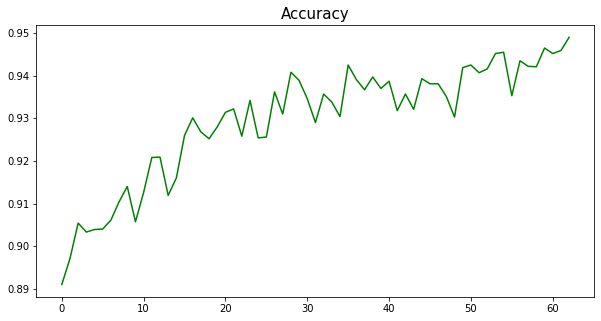

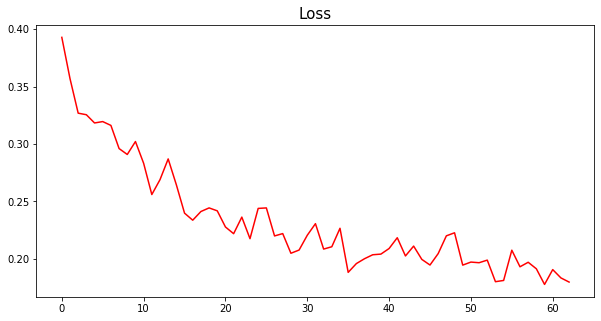

In [ ]:
fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Accuracy", fontsize=15)
ax_real.plot(test_accuracy_history, c='green')

fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Loss", fontsize=15)
ax_real.plot(test_loss_history, c='red')

# Классификация рукописных цифр (сверточные нейронные сети 1 версия)

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True   # если убрать, то скорость увеличится

Скачиваем картинки рукописных цифр

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

# данные в дробных числах
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
print("Старая размерность: ",X_train.shape, X_test.shape)

# доьавляем еще одно измерение
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
print("Новая размерность: ",X_train.shape, X_test.shape)

Старая размерность:  torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
Новая размерность:  torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


Создаем класс нейросети

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # после 1 слоя хотим сохранить размер 28х28, добавляем паддинг
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,padding=2)  # bias=False
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,padding=0)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)   

        # растянем в один вектор потом

        self.fc1 = torch.nn.Linear(5*5*16, 120)  # сколько нейронов на входе, на выходе
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    # применяем слои к входному вектору
    def forward(self,x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool2(x)

        # растянем 4х мерный тензор в двумерный
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)

        return x

lenet5 = LeNet5()

Подключим GPU и выберем оптимайзер и loss функцию

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обнуляем градиент
        optimizer.zero_grad()
        
        # выбираем какие картинки войдут в батч
        batch_indexes = order[start_index:start_index+batch_size]
        
        # отправляем батч на GPU
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # пропускаем батч через forward
        preds = lenet5.forward(X_batch) 
        
        # считаем ошибку, градиенты и делаем шаг град.спуска
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # следим за качеством
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())   # пишем .data чтобы не хранить все вычисления, а только числа
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

Графики

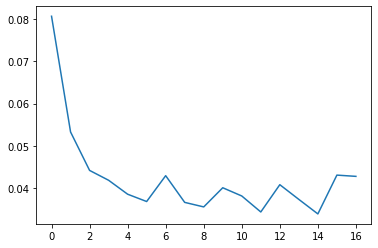

In [ ]:
# plt.plot(test_accuracy_history);
# plt.plot(test_loss_history);

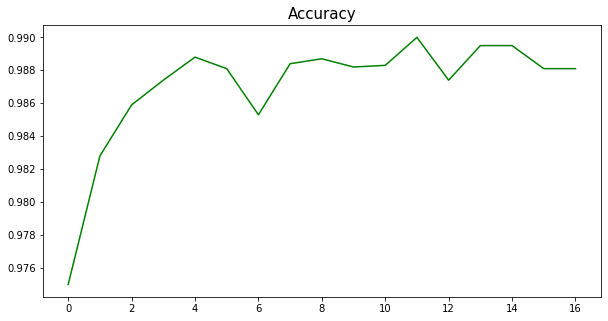

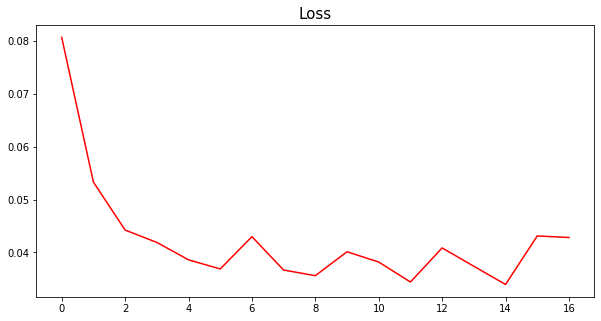

In [ ]:
fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Accuracy", fontsize=15)
ax_real.plot(test_accuracy_history, c='green')

fig = plt.figure(figsize=(10,5))
ax_real = fig.add_subplot()
ax_real.set_title("Loss", fontsize=15)
ax_real.plot(test_loss_history, c='red')

# Сверточные нейронные сети (2 версия)

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Скачиваем картинки рукописных цифр

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

# данные в дробных числах
X_train = X_train.float()
X_test = X_test.float()

# если нужно отнормировать данные
# X_train /= 255.
# X_test /= 255.

# добавляем еще одно измерение
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Класс нейронной сети

In [4]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='max',
                 conv_size=3,
                 use_batch_norm=True):   # теперь можно задать параметры по умолчанию (размер свертки, нормализацию, пулинг)
        super(LeNet5(),self).__init__()

        self.conv_size=conv_size
        self.use_batch_norm = use_batch_norm

# выбираем функ активации  еще варианты: ELU, Hardtanh, LeakyReLU, LogSigmoid, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, Sigmoid, Softplus, Softshrink, Softsign, Tanh, Tanhshrink, Hardshrink.
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError

# выбираем пуллинг
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

# выбираем размер свертки  (две 3х3 лучше 5х5)
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError



        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)   # если вектор, а не картинка, то BatchNorm1d   # 6 - число каналов у картинки
        self.pool1 = pooling_layer


        if conv_size == 5:
            self.conv2 = self.conv1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError



        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)    
        self.fc2 = torch.nn.Linear(120, 84)      
        self.fc3 = torch.nn.Linear(84, 10)


    def forward(self,x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))

        x = self.act1(x)

        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))

        x = self.act2(x)

        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x     

Тренеруем сеть

In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    # Подключаем GPU
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=1e-5)   #  weight_decay это l2-регуляризация

    batch_size = 100
    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # тренеруем
    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()  # показываем сети, что мы ее тестируем, чтобы нормализация не работада
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

Проверяем точность и ошибку при различных гиперпараметрах

In [ ]:
accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] =  train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

!! почему-то ломается сеанс !!

Поиск функции активации с наименьшим затуханием градиента  --  torch.nn.Hardshrink()

In [11]:
import torch
import numpy as np

seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()
        
        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)
    
def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

#  ELU, Hardtanh, LeakyReLU, LogSigmoid, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, Sigmoid, Softplus, Softshrink, Softsign, Tanh, Tanhshrink, Hardshrink
activation_mass = [torch.nn.Hardtanh(), torch.nn.LogSigmoid(),torch.nn.PReLU(),torch.nn.Softshrink(),torch.nn.Softsign(),torch.nn.Tanhshrink(),torch.nn.Hardshrink(),torch.nn.ReLU6(),torch.nn.SELU(),torch.nn.CELU(),torch.nn.Softplus(),torch.nn.Softshrink(), torch.nn.ELU(), torch.nn.LeakyReLU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.Tanh()]

for activation in activation_mass:
    net = SimpleNet(activation=activation)
    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))
        
    print("{}: ".format(activation),round(np.mean(fc1_grads), 5))


Hardtanh(min_val=-1.0, max_val=1.0):  0.30436
LogSigmoid():  0.25089
PReLU(num_parameters=1):  0.39319
Softshrink(0.5):  0.14098
Softsign():  0.06398
Tanhshrink():  0.02375
Hardshrink(0.5):  0.73793
ReLU6():  0.38862
SELU():  0.6178
CELU(alpha=1.0):  0.46232
Softplus(beta=1, threshold=20):  0.23692
Softshrink(0.5):  0.31693
ELU(alpha=1.0):  0.45583
LeakyReLU(negative_slope=0.01):  0.45289
ReLU():  0.4213
Sigmoid():  0.00706
Tanh():  0.16664


In [ ]:
from torchvision.models import resnet18

# Задача Kaggle (Cleaned vs Dirty)

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/My Drive/Colab Notebooks/Кружок samsung/Kaggle Cleaned vs Dirty'

sample_submission.csv  test  train


## Подготавливаем и увеличиваем данные

Локально создаем папки train и val

In [5]:
data_root = '/content/drive/My Drive/Colab Notebooks/Кружок samsung/Kaggle Cleaned vs Dirty'

In [56]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 600.44it/s]


In [15]:
!ls val

cleaned  dirty


In [65]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy


# трансформация картинок   https://pytorch.org/vision/main/transforms.html
from torchvision import transforms, models
train_transforms = transforms.Compose([  # сначала аугментация данных
    # transforms.RandomResizedCrop(224),   # Обрезать данное изображение в случайном месте 
    transforms.Resize((224, 224)),
    # transforms.RandomRotation(20),         # Поверните изображение на угол
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),            # Произвольное изменение яркости, контрастности, насыщенности и оттенка изображения
    # transforms.Grayscale(),   # Преобразование изображения в оттенки серого
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# трансформация картинок
val_transforms = transforms.Compose([  # производим изменения посоедовательно
    transforms.Resize((224, 224)),  #  делаем одинаковый размер изображений
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # нормируем картинки для работы с ResNet
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)    # ImageFolder добавляет к метке картинки название папки, где она лежит  -  удобно для сохранения датасета при классификации
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

# батч-режим
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [59]:
len(train_dataloader), len(train_dataset)

(8, 32)

Чтобы посмотреть на картинки в dataLoader нужно сделать обратные преобразования

In [ ]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Строим модель

In [ ]:
'''
увеличиваем датасет на этапе копирования -- done
батч = 4 -- done
чб фильтр -- done
повороты/аугментации
захватываем тарелку с краями -- done
сделать два дополнительных слоя -- done
получать оценку качества на основе заданных n трансформаций
калибровка
отказаться от валидационного множества
сначала делаем копии, потом уже разбиваем на тест\контроль
центрировать изображение
двигать изображение
добавить переспективы в фильтр
остальные фильтры стыбзить
делать все чисто в чб
AdamW вместо адама
в конце колабровка
'''

In [67]:
model = models.resnet18(pretrained=True)

# Замораживаем все слои, чтобы они не обучались (датасет маленький)
for param in model.parameters():
    param.requires_grad = False

# меняем последний полносвязный слой для предсказания двух классов
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# функция ошибки
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), amsgrad=True, lr=1.0e-3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1.0e-3)
# Планировщик, меняющий шаг градиентного спуска
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Тренеруем модель

In [68]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss1=[]
    acc1=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Что происходит каждую эпоху
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Обозначаем фазы тренеровки и валидации, чтобы не менять веса нейронов при валидации

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                # Обертка для созранения только значения ошибки, а не всей истории изменения
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            loss1.append(epoch_loss)
            acc1.append(epoch_acc)
    print("loss: ",loss1,"\nacc: ",acc1)
    return model

In [69]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

Epoch 1/99:



100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

Epoch 2/99:



100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

Epoch 3/99:



100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

Epoch 4/99:



100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

Epoch 5/99:



100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

Epoch 6/99:



100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Epoch 7/99:



100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Epoch 8/99:



100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Epoch 9/99:



100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Epoch 10/99:



100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

Epoch 11/99:



100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Epoch 12/99:



100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

Epoch 13/99:



100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Epoch 14/99:



100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

Epoch 15/99:



100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Epoch 16/99:



100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

Epoch 17/99:



100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

Epoch 18/99:



100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

Epoch 19/99:



100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

Epoch 20/99:



100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

Epoch 21/99:



100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Epoch 22/99:



100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Epoch 23/99:



100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Epoch 24/99:



100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

Epoch 25/99:



100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

Epoch 26/99:



100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Epoch 27/99:



100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

Epoch 28/99:



100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

Epoch 29/99:



100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Epoch 30/99:



100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

Epoch 31/99:



100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Epoch 32/99:



100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

Epoch 33/99:



100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

Epoch 34/99:



100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Epoch 35/99:



100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Epoch 36/99:



100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

Epoch 37/99:



100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

Epoch 38/99:



100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

Epoch 39/99:



100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

Epoch 40/99:



100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

Epoch 41/99:



100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

Epoch 42/99:



100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Epoch 43/99:



100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Epoch 44/99:



100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

Epoch 45/99:



100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Epoch 46/99:



100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Epoch 47/99:



100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

Epoch 48/99:



100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

Epoch 49/99:



100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

Epoch 50/99:



100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

Epoch 51/99:



100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

Epoch 52/99:



100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

Epoch 53/99:



100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Epoch 54/99:



100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Epoch 55/99:



100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

Epoch 56/99:



100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Epoch 57/99:



100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

Epoch 58/99:



100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Epoch 59/99:



100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Epoch 60/99:



100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

Epoch 61/99:



100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

Epoch 62/99:



100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

Epoch 63/99:



100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

Epoch 64/99:



100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

Epoch 65/99:



100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

Epoch 66/99:



100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

Epoch 67/99:



100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Epoch 68/99:



100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

Epoch 69/99:



100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

Epoch 70/99:



100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

Epoch 71/99:



100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Epoch 72/99:



100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

Epoch 73/99:



100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Epoch 74/99:



100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Epoch 75/99:



100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

Epoch 76/99:



100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

Epoch 77/99:



100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

Epoch 78/99:



100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

Epoch 79/99:



100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

Epoch 80/99:



100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

Epoch 81/99:



100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Epoch 82/99:



100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Epoch 83/99:



100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

Epoch 84/99:



100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

Epoch 85/99:



100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

Epoch 86/99:



100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

Epoch 87/99:



100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

Epoch 88/99:



100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

Epoch 89/99:



100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

Epoch 90/99:



100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

Epoch 91/99:



100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

Epoch 92/99:



100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

Epoch 93/99:



100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

Epoch 94/99:



100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

Epoch 95/99:



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Epoch 96/99:



100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

Epoch 97/99:



100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Epoch 98/99:



100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Epoch 99/99:



100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


loss:  [0.9489702545106411, 0.8152023553848267, 0.7885091230273247, 0.7481019794940948, 0.6700592115521431, 0.7163382768630981, 0.664708137512207, 0.715275228023529, 0.5955774933099747, 0.6872515678405762, 0.47617413848638535, 0.740267351269722, 0.6976950913667679, 0.6986652910709381, 0.49203355610370636, 0.732951819896698, 0.4594030976295471, 0.7255885601043701, 0.45884834602475166, 0.7082091867923737, 0.4006048683077097, 0.7470790892839432, 0.4215315654873848, 0.7145892083644867, 0.33498410508036613, 0.726529061794281, 0.3293289318680763, 0.7386450171470642, 0.45556322671473026, 0.7107575535774231, 0.2851844634860754, 0.7465953230857849, 0.3777784314006567, 0.7226952910423279, 0.4447490442544222, 0.7291273772716522, 0.42382584512233734, 0.7271547913551331, 0.38469013199210167, 0.75232994556427, 0.25441111996769905, 0.7356787472963333, 0.31976518034935, 0.7019668519496918, 0.32220119051635265, 0.704573780298233, 0.3134697526693344, 0.7064012289047241, 0.40572577342391014, 0.7078661322

## Предсказываем

Создали папку test где лежат изображения

In [70]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

Переписываем Folder чтобы он возвращал имя изображения

In [71]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [72]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 186/186 [00:05<00:00, 31.80it/s]


Картинки с вероятностями загрязнения

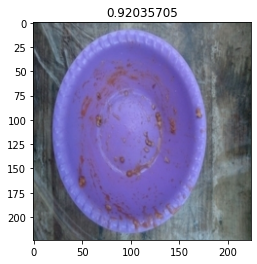

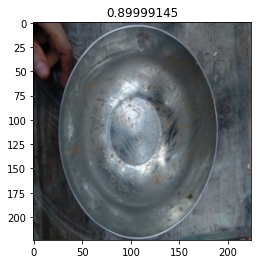

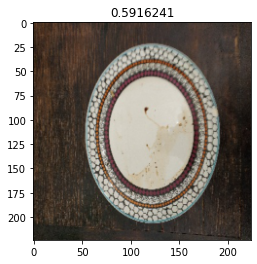

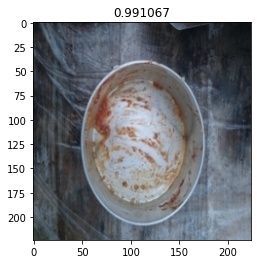

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


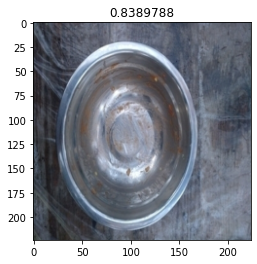

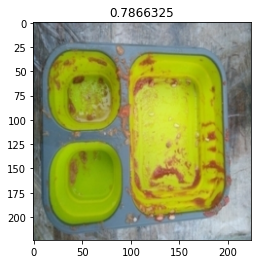

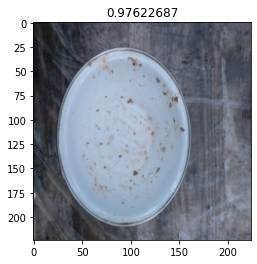

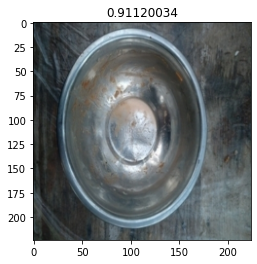

In [49]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

## Подготовка файла ответов

In [73]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [74]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

<ipython-input-74-402366df2ea6>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,cleaned
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [75]:
submission_df.to_csv('predict.csv')

В Colab лучше очищать папки, которые больше не нужны

In [55]:
!rm -rf train val test